### Bayesian Data Analysis, 3rd ed
##  Chapter 5, demo 1

Hierarchical model for Rats experiment (BDA3, p. 102).

In [1]:
from __future__ import division
import numpy as np
from scipy.stats import beta
from scipy.special import gammaln

%matplotlib inline
import matplotlib.pyplot as plt

/Users/Jinkyoo/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# edit default plot settings
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=16)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.rc('axes', color_cycle=(plt.rcParams['lines.color'],)) # Disable color cycle

/Users/Jinkyoo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# rat data (BDA3, p. 102)
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
M = len(y)

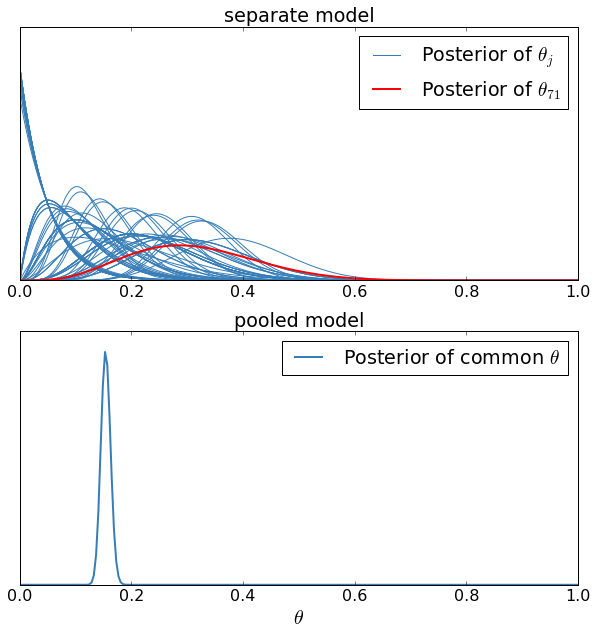

In [4]:
# plot the separate and pooled models
plt.figure(figsize=(10,10))
x = np.linspace(0, 1, 250)

# separate (alpha_j=1, beta_j=1)
plt.subplot(2, 1, 1)
lines = plt.plot(x, beta.pdf(x[:,None], y[:-1] + 1, n[:-1] - y[:-1] + 1),
                 linewidth=1)


# highlight the last line
line1, = plt.plot(x, beta.pdf(x, y[-1] + 1, n[-1] - y[-1] + 1), 'r')
plt.legend((lines[0], line1),
           (r'Posterior of $\theta_j$', r'Posterior of $\theta_{71}$'))
plt.yticks(())
plt.title('separate model')

# pooled
plt.subplot(2, 1, 2)
plt.plot(x, beta.pdf(x, y.sum() + 1, n.sum() - y.sum() + 1),
         linewidth=2, label=(r'Posterior of common $\theta$'))
plt.legend()
plt.yticks(())
plt.xlabel(r'$\theta$', fontsize=20)
plt.title('pooled model');


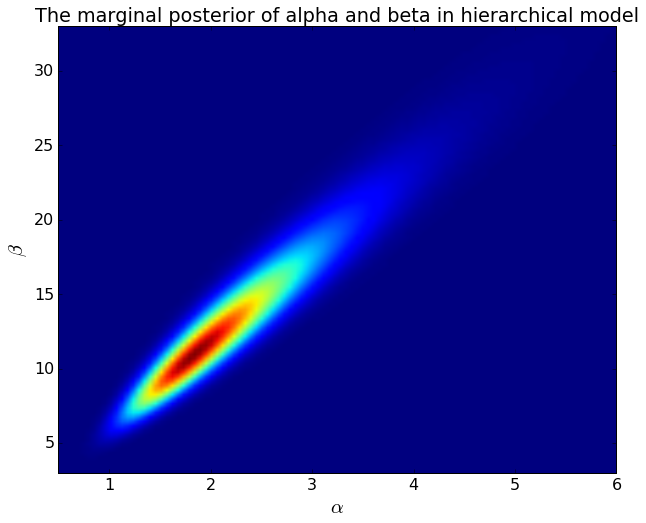

In [92]:
# compute the marginal posterior of alpha and beta in the hierarchical model in a grid
A = np.linspace(0.5, 6, 100)
B = np.linspace(3, 33, 100)
# calculated in logarithms for numerical accuracy
lp = (
  - 5/2 * np.log(A + B[:,None]) # A+B[:,None] is a matrix
  + np.sum(
        gammaln(A + B[:,None])
      - gammaln(A)
      - gammaln(B[:,None])
      + gammaln(A + y[:,None,None])
      + gammaln(B[:,None] + (n - y)[:,None,None])
      - gammaln(A + B[:,None] + n[:,None,None]),
        axis=0
    )
)
# subtract the maximum value to avoid over/underflow in exponentation
a=lp.max()
lp -= lp.max()
p = np.exp(lp)

# plot the marginal posterior
fig = plt.figure(figsize=(10,8))
plt.imshow(p, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.title('The marginal posterior of alpha and beta in hierarchical model');

In [94]:
# sample from the posterior grid of alpha and beta
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/p.sum()),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])


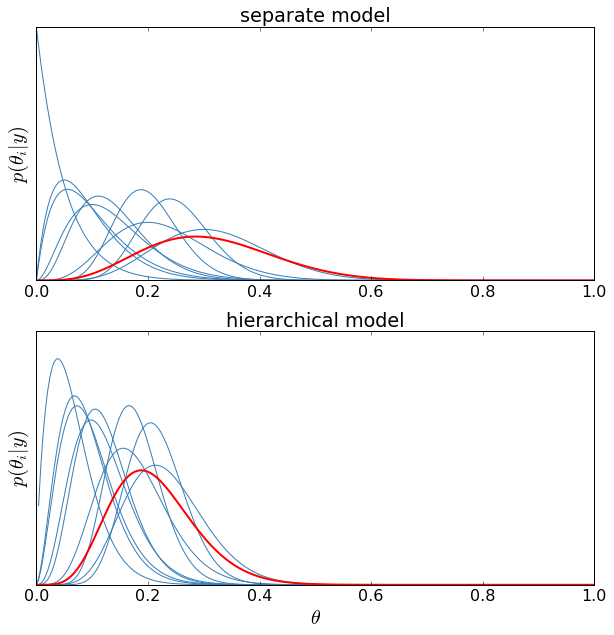

In [95]:
# And finally compare the separate model and the hierarchical model
plt.figure(figsize=(10,10))
x = np.linspace(0, 1, 250)

# first plot the separate model (same as above)
plt.subplot(2, 1, 1)
# note that for clarity only every 7th distribution is plotted
plt.plot(x, beta.pdf(x[:,None], y[7:-1:7] + 1, n[7:-1:7] - y[7:-1:7] + 1),
         linewidth=1)
# highlight the last line
plt.plot(x, beta.pdf(x, y[-1] + 1, n[-1] - y[-1] + 1), 'r')
plt.yticks(())
plt.title('separate model')
plt.ylabel(r'$p(\theta_i|y)$', fontsize=20)

# And the hierarchical model. Note that these marginal posteriors for theta_j are
# more narrow than in the separate model case, due to the borrowed information from
# the other theta_j's.
plt.subplot(2, 1, 2)
# note that for clarity only every 7th distribution is plotted
lines = plt.plot(
    x,
    np.mean(
        beta.pdf(
            x[:,None],
            y[7::7] + samp_A[:,None,None],
            n[7::7] - y[7::7] + samp_B[:,None,None]
        ),
        axis=0
    ),
    linewidth=1,
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
plt.yticks(())
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel(r'$p(\theta_i|y)$', fontsize=20)
plt.title('hierarchical model');